In [1]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler

from statsmodels.formula.api import ols



from scipy import stats
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings 

warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
X = pd.read_csv('../raw/X.csv')
y  = pd.read_csv('../raw/y.csv', header=None)
y.columns = ['price']

In [3]:
datetime = pd.to_datetime(X.date)

In [4]:
week = datetime.dt.strftime("%W")
week

0        40
1        33
2        32
3        13
4        28
         ..
17285    09
17286    20
17287    19
17288    48
17289    02
Name: date, Length: 17290, dtype: object

In [5]:
X['week'] = week

In [6]:
week_df = pd.concat([X['week'], y], axis=1)

(390000, 510000)

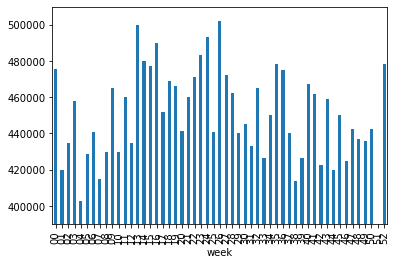

In [7]:
week_df.groupby(['week']).price.median().plot(kind='bar')
plt.ylim(390000, 510000)


In [8]:
# grap top 10 most profitable weeks by mean and median and find overlap.
median = set(week_df.groupby(['week']).price.median().sort_values(ascending=False)[:10].index)
mean = set(week_df.groupby(['week']).price.median().sort_values(ascending=False)[:10].index)

mean.union(median)

# up to 10 the mean and medain months are exactly 

{'00', '13', '14', '15', '16', '23', '24', '26', '35', '52'}

In [9]:
month = datetime.dt.strftime("%m")
X['month'] = month

(500000, 600000)

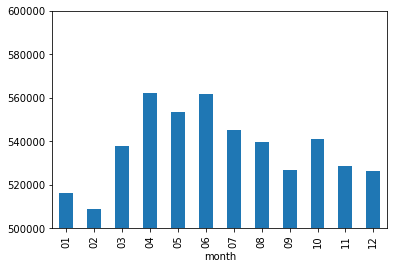

In [10]:
month_df = pd.concat([X['month'], y], axis=1)
month_df.groupby(['month']).price.mean().plot(kind='bar')
plt.ylim(500000,600000)

In [11]:
# Try peak vs off peak dummies and then monthly dummies

month_dummies = pd.get_dummies(month_df.month)
week_dummies_total = pd.get_dummies(week_df.week)
week_dummies_total.columns = [str(x) for x in week_dummies_total.columns]

In [12]:
week_dummies_top10 = week_dummies_total[['00', '13', '14', '15', '16', '23', '24', '26', '35', '52']]

In [13]:
# Let's evaluate the model.

test_model = pd.concat([X, week_dummies_top10], axis=1)

In [14]:
test_model = pd.concat([test_model, month_dummies],axis=1)

In [15]:
pd.concat([week_dummies_top10, month_dummies], axis=1).to_csv("../cleanedData/weekMonthDummies.csv")

In [16]:
test_model.drop(columns=['id', 'date'], inplace = True)

In [17]:
# Split the data into training and test data
X_train, X_test, y_train, y_test = train_test_split(test_model, y,               # Pass in our X and y
                                                    random_state=42,    # Abritary select a random_state 
                                                    test_size=.2        # Split test size to be 20% of full data.
                                                   )

In [18]:
lr = LinearRegression()
lr.fit(X_train.iloc[:,20:], y_train)
y_hat = lr.predict(X_test.iloc[:,20:])
RMSE = mean_squared_error(y_test, y_hat)
RMSE**0.5

365427.6229977706

In [19]:
list(enumerate(X_train.columns))

[(0, 'bedrooms'),
 (1, 'bathrooms'),
 (2, 'sqft_living'),
 (3, 'sqft_lot'),
 (4, 'floors'),
 (5, 'waterfront'),
 (6, 'view'),
 (7, 'condition'),
 (8, 'grade'),
 (9, 'sqft_above'),
 (10, 'sqft_basement'),
 (11, 'yr_built'),
 (12, 'yr_renovated'),
 (13, 'zipcode'),
 (14, 'lat'),
 (15, 'long'),
 (16, 'sqft_living15'),
 (17, 'sqft_lot15'),
 (18, 'week'),
 (19, 'month'),
 (20, '00'),
 (21, '13'),
 (22, '14'),
 (23, '15'),
 (24, '16'),
 (25, '23'),
 (26, '24'),
 (27, '26'),
 (28, '35'),
 (29, '52'),
 (30, '01'),
 (31, '02'),
 (32, '03'),
 (33, '04'),
 (34, '05'),
 (35, '06'),
 (36, '07'),
 (37, '08'),
 (38, '09'),
 (39, '10'),
 (40, '11'),
 (41, '12')]

In [20]:
# When I ran the comvined model, I got a terribel result.

### Let's creat peak season and off season

In [21]:
def peak_season(month):
    if month in [4,5,6]:
        return 'peak'
    elif month in [1,2,9,11,12]:
        return 'offpeak'
    else:
        return 'normal_season'

In [22]:
test = pd.concat([X, y], axis=1)
test.month = test.month.astype(int)

In [23]:
test['peak'] = test.month.apply(peak_season)

In [24]:
peak = test[test.peak == 'peak']
offpeak = test[test.peak == 'offpeak']
normal = test[test.peak == 'normal_season']

(490000, 560000)

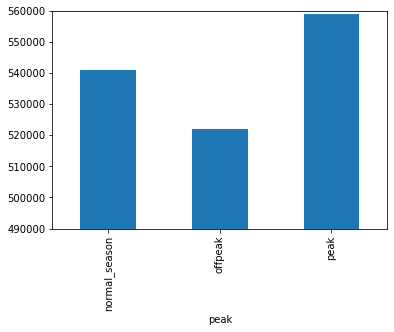

In [26]:
test.groupby('peak').price.mean().plot(kind='bar')
plt.ylim(490000, 560000)

### Perform statistical tests between the groups

In [138]:
# peak vs off peak ttest 
print(peak.price.mean() - offpeak.price.mean())
stats.levene(peak.price, offpeak.price) # Rejected
stats.ttest_ind(peak.price, offpeak.price, equal_var=False)

36720.238000085636


Ttest_indResult(statistic=5.173833459270526, pvalue=2.334085061315023e-07)

In [139]:
# peak vs regular season
print(peak.price.mean()-normal.price.mean())
stats.levene(peak.price, normal.price) # Failed to reject
stats.ttest_ind(peak.price, normal.price) # significant 

17824.835047457367


Ttest_indResult(statistic=2.5425659344696623, pvalue=0.011016854999620442)

In [140]:
# normal season vs offpeak
print(normal.price.mean() -  offpeak.price.mean())
stats.levene(normal.price, offpeak.price) # Rejected
stats.ttest_ind(normal.price, offpeak.price, equal_var=False)

18895.40295262827


Ttest_indResult(statistic=2.7962682450352854, pvalue=0.005178077743120801)

In [141]:
season_dummies = pd.get_dummies(test.peak)

In [145]:
# drop one of the columns to avoid colinaerity
print(len(peak), len(normal), len(offpeak))
season_dummies.drop(columns=['normal_season'], inplace=True)

5485 6311 5494


In [146]:
season_dummies.to_csv("../cleanedData/seasonDummies.csv", index=False)

In [131]:
# weeks look a little bit like a sin wave. let's reshape the data to be between 0 and 2pi
np.sin(test.week.astype(int))

0        0.745113
1        0.999912
2        0.551427
3        0.420167
4        0.270906
           ...   
17285    0.412118
17286    0.912945
17287    0.149877
17288   -0.768255
17289    0.909297
Name: week, Length: 17290, dtype: float64

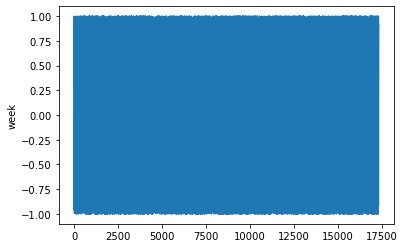

In [132]:
sns.lineplot(data=np.sin(test.week.astype(int)))

## Let's do the same to our holdout data

In [157]:
df = pd.read_csv('../raw/kc_holdout_data.csv', index_col=0)
df.shape

(4323, 20)

In [158]:
month = pd.to_datetime(df.date)

In [159]:
month = month.dt.strftime("%m").astype(int)

In [160]:
df['month'] = month

In [161]:
df['peak']=df.month.apply(peak_season)


In [165]:
df.groupby(['peak']).id.count()

peak
normal_season    1616
offpeak          1379
peak             1328
Name: id, dtype: int64

In [163]:
df.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month,peak
0,1974300020,20140827T000000,4,2.50,2270,11500,1.0,0,0,3,...,730,1967,0,98034,47.7089,-122.241,2020,10918,8,normal_season
1,1974300020,20150218T000000,4,2.50,2270,11500,1.0,0,0,3,...,730,1967,0,98034,47.7089,-122.241,2020,10918,2,offpeak
2,3630020380,20141107T000000,3,2.50,1470,1779,2.0,0,0,3,...,310,2005,0,98029,47.5472,-121.998,1470,1576,11,offpeak
3,1771000290,20141203T000000,3,1.75,1280,16200,1.0,0,0,3,...,250,1976,0,98077,47.7427,-122.071,1160,10565,12,offpeak
4,5126310470,20150115T000000,4,2.75,2830,8126,2.0,0,0,3,...,0,2005,0,98059,47.4863,-122.140,2830,7916,1,offpeak


In [166]:
season_dummies= pd.get_dummies(df.peak)

In [169]:
season_dummies.drop(columns=['normal_season'], inplace=True)

In [171]:
season_dummies.to_csv('../cleanedData/holdoutSeason.csv')